In [68]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [69]:
df_train = pd.read_csv('/kaggle/input/playground-series-s5e4/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s5e4/test.csv')
df_sample = pd.read_csv('/kaggle/input/playground-series-s5e4/sample_submission.csv')
df_original = pd.read_csv('/kaggle/input/podcast-listening-time-prediction-dataset/podcast_dataset.csv')

## EDA 

Podcast_Name
Type: string
Values: Names of popular podcasts.

Episode_Title
Type: string
Values: Titles of the episodes.

Episode_Length
Type: float (minutes)
Values: Length of the episode in minutes. Example: 5.0, 10.0, 30.0, 45.0, 60.0, 90.0.

Genre
Type: string
Values: "Technology", "Education", "Comedy", "Health", "True Crime", "Business", "Sports", "Lifestyle", "News", "Music".

Host_Popularity
Type: float (scale 0-100)
Values: A score indicating the popularity of the host. Example: 50.0, 75.0, 90.0.

Publication_Day
Type: string
Values: Day of the week the episode was published. Example: "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday".

Publication_Time
Type: string
Values: "Morning", "Afternoon", "Evening", "Night".

Guest_Popularity
Type: float (scale 0-100)
Values: A score indicating the popularity of the guest (if any). Example: 20.0, 50.0, 85.0.

Number_of_Ads
Type: int
Values: Number of advertisements within the episode. Example: 0, 1, 2, 3.

Episode_Sentiment
Type: string
Values: Sentiment of the episode's content. Example: "Positive", "Neutral", "Negative".

Listening_Time
Type: float (minutes)
Values: The actual average listening duration (target variable).

In [70]:
df_train.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [71]:
df_original.head()

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,Healthy Living,Episode 77,99.25,Health,21.37,Thursday,Night,70.22,3,Positive,55.158695
1,Mystery Matters,Episode 6,19.43,True Crime,47.19,Friday,Evening,75.15,1,Neutral,7.686559
2,Current Affairs,Episode 1,117.03,News,96.33,Sunday,Night,57.95,3,Neutral,110.064645
3,Mystery Matters,Episode 38,16.97,True Crime,25.73,Monday,Night,24.19,0,Positive,12.000380
4,Humor Hub,Episode 73,83.48,Comedy,76.69,Tuesday,Afternoon,42.31,3,Positive,NaN


In [72]:
df_united = pd.concat([df_train, df_original], ignore_index=True)

In [73]:
print(f'Length train: {len(df_train)}')
print(f'Length original: {len(df_original)}')

Length train: 750000
Length original: 52500


In [74]:
# Missing procent
df_original.isna().sum() / len(df_original)

Podcast_Name                   0.000000
Episode_Title                  0.000000
Episode_Length_minutes         0.099924
Genre                          0.000000
Host_Popularity_percentage     0.000000
Publication_Day                0.000000
Publication_Time               0.000000
Guest_Popularity_percentage    0.100152
Number_of_Ads                  0.000000
Episode_Sentiment              0.000000
Listening_Time_minutes         0.102762
dtype: float64

In [75]:
df_train.isna().sum() / len(df_train)

id                             0.000000
Podcast_Name                   0.000000
Episode_Title                  0.000000
Episode_Length_minutes         0.116124
Genre                          0.000000
Host_Popularity_percentage     0.000000
Publication_Day                0.000000
Publication_Time               0.000000
Guest_Popularity_percentage    0.194707
Number_of_Ads                  0.000001
Episode_Sentiment              0.000000
Listening_Time_minutes         0.000000
dtype: float64

## Feature base preprocessing

<Axes: >

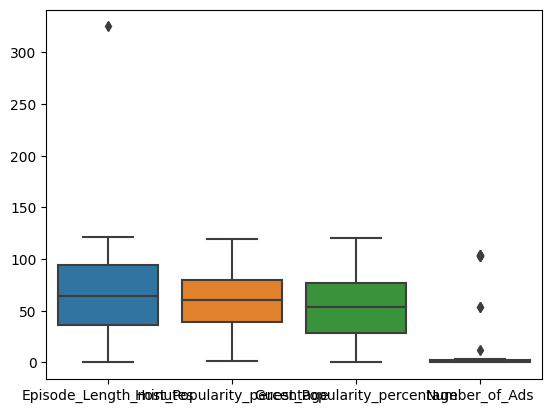

In [76]:
num_columns = ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Number_of_Ads']
sns.boxplot(df_united[num_columns])

In [77]:
from sklearn.base import BaseEstimator, TransformerMixin
from scipy import stats

class BasePreprocessing(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X['Episode_Title'] = X['Episode_Title'].apply(lambda x: int(x[8:]))
        X['Host_Popularity_percentage'] = X['Host_Popularity_percentage'].apply(lambda x: 100 if x > 100 else x)

        # Clear outliers and NaN
        for col in num_columns:
            X[col] = X[col].fillna(X[col].median())
            
            # calculate IQR for column Height
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            
            # identify outliers
            threshold = 1.5
            X = X.loc[(X[col] > Q1 - threshold * IQR) & (X[col] < Q3 + threshold * IQR)]
        X = X.loc[X['Listening_Time_minutes'].notnull()]
        return X

In [78]:
df_train = pd.read_csv('/kaggle/input/playground-series-s5e4/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s5e4/test.csv')
df_sample = pd.read_csv('/kaggle/input/playground-series-s5e4/sample_submission.csv')
df_original = pd.read_csv('/kaggle/input/podcast-listening-time-prediction-dataset/podcast_dataset.csv')

df_train = BasePreprocessing().fit_transform(df_train)
df_original = BasePreprocessing().fit_transform(df_original)

df_united = pd.concat([df_train, df_original], ignore_index=True)

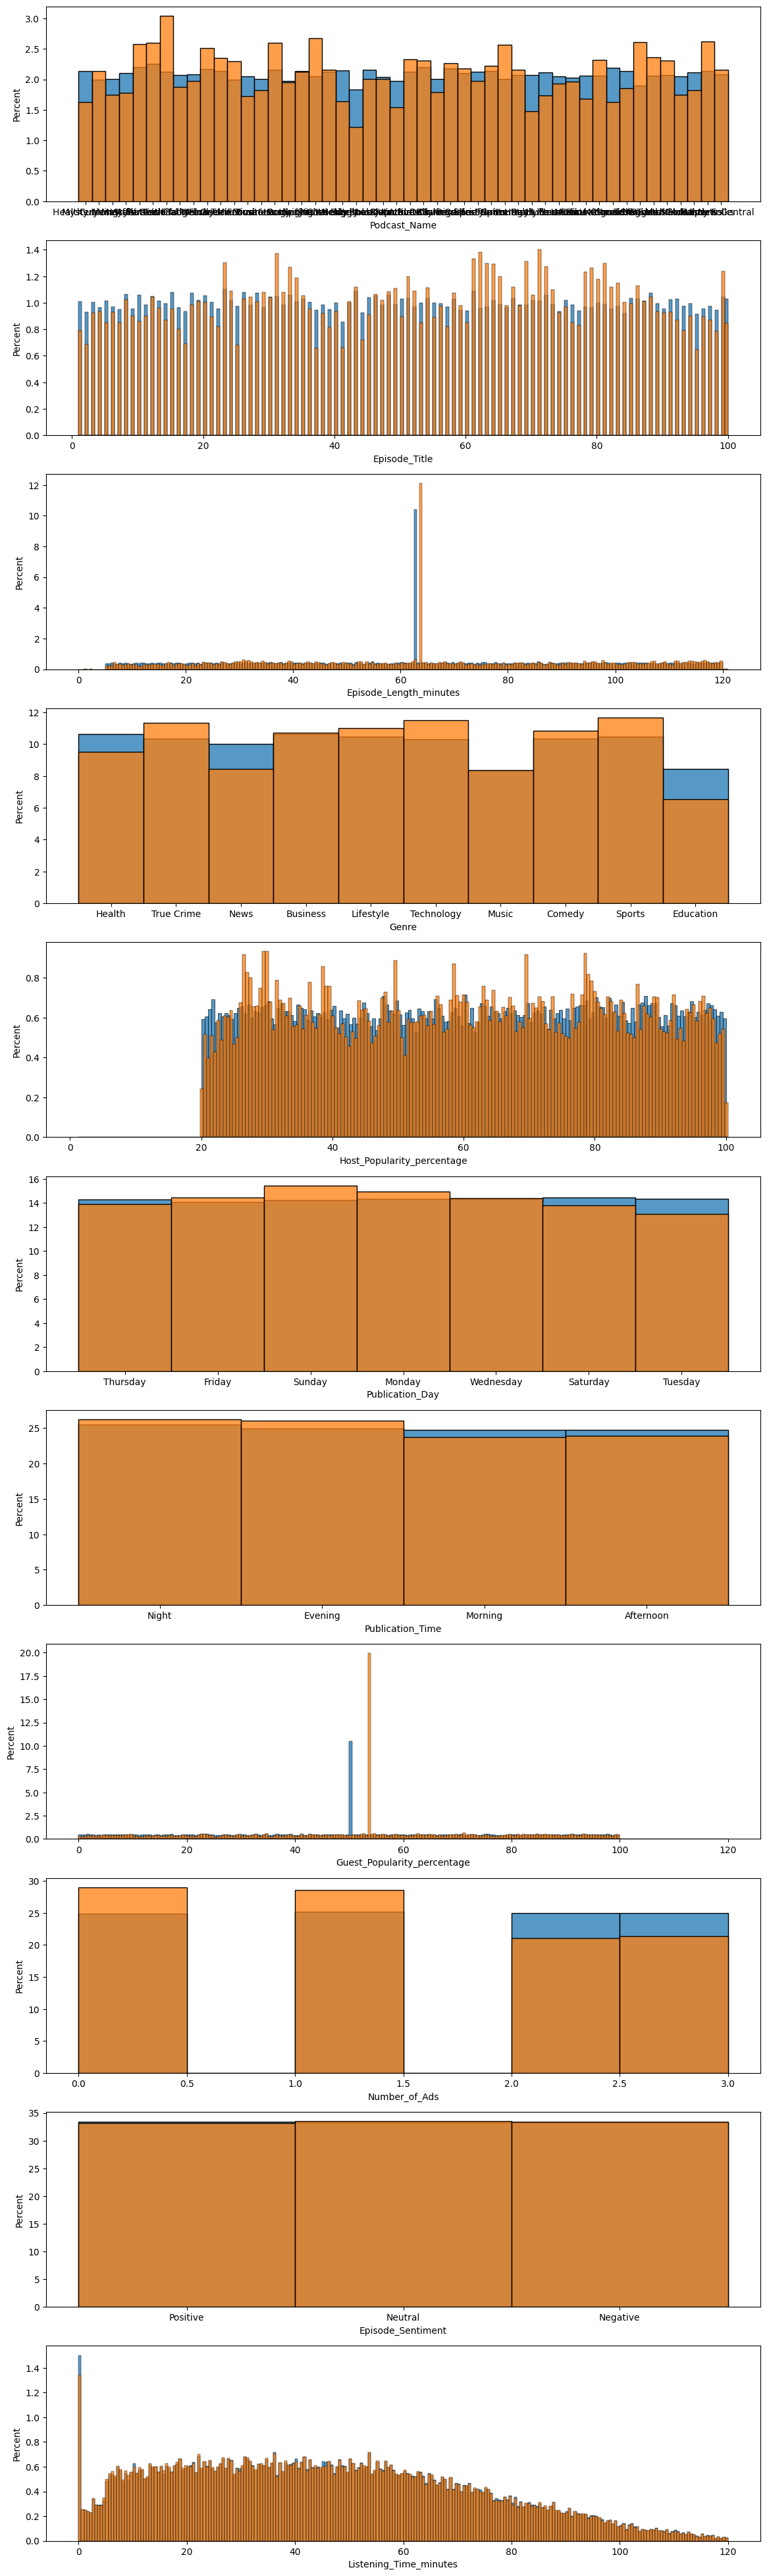

In [79]:
fig, axs = plt.subplots(len(df_original.columns), figsize=(14, 50))
for i, column in enumerate(df_original.columns):
    sns.histplot(data=df_original, x=column, ax=axs[i], stat='percent', binwidth=0.5)
    sns.histplot(data=df_train, x=column, ax=axs[i], stat='percent', binwidth=0.5)
plt.show()

<Axes: xlabel='Listening_Time_minutes', ylabel='Percent'>

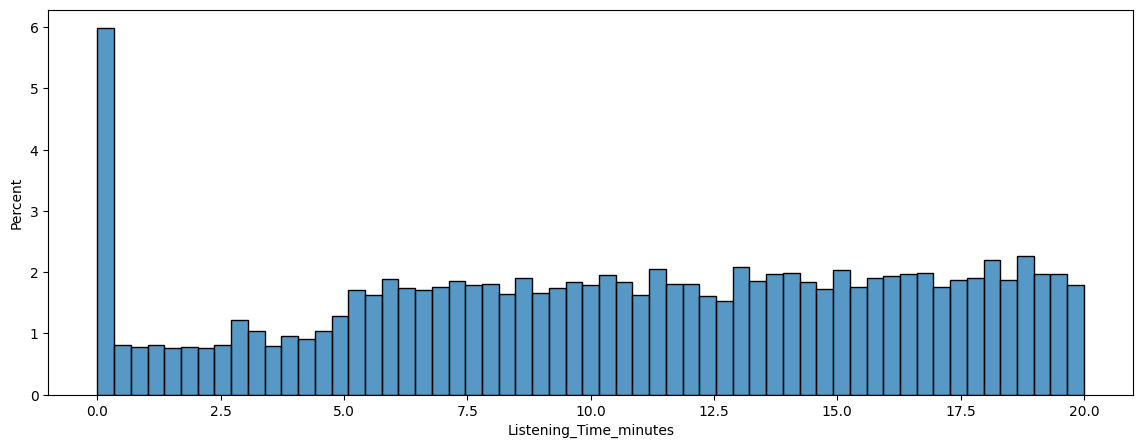

In [80]:
fig, ax = plt.subplots(figsize=(14, 5))
df_low_target = df_united.loc[df_united['Listening_Time_minutes'] < 20]
sns.histplot(df_low_target['Listening_Time_minutes'], ax=ax, stat='percent')

In [81]:
len(df_united.loc[(df_united['Listening_Time_minutes'] == 0)]) / len(df_united)

0.011496747564593932

In [82]:
class TargetTransform(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X['Listening_Time_zero'] = X['Listening_Time_minutes'].apply(lambda x: int(x == 0))
        return X

TargetTransform().fit_transform(df_united).tail(10)

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,Listening_Time_zero
797085,NaN,Money Matters,4,40.06,Business,98.84,Saturday,Morning,48.960,1.0,Positive,14.644270,0
797086,NaN,Sport Spot,86,29.47,Sports,48.71,Sunday,Morning,50.035,3.0,Neutral,6.819700,0
797087,NaN,Crime Chronicles,69,119.95,True Crime,21.55,Saturday,Afternoon,36.440,0.0,Positive,116.811116,0
797088,NaN,Brain Boost,71,72.87,Education,21.36,Tuesday,Morning,50.035,0.0,Negative,52.430865,0
797089,NaN,Market Masters,23,33.35,Business,63.23,Monday,Morning,90.810,1.0,Positive,32.133509,0
797090,NaN,Home & Living,17,24.81,Lifestyle,66.15,Monday,Evening,98.630,1.0,Neutral,20.573795,0
797091,NaN,Melody Mix,9,92.15,Music,89.61,Saturday,Night,25.820,2.0,Negative,76.198459,0
797092,NaN,Comedy Corner,24,112.27,Comedy,26.33,Saturday,Night,55.290,0.0,Neutral,107.602135,0
797093,NaN,Business Briefs,85,62.87,Business,41.47,Wednesday,Afternoon,33.580,0.0,Neutral,17.220998,0
797094,NaN,Healthy Living,54,94.35,Health,91.08,Monday,Afternoon,92.540,3.0,Neutral,52.102024,0


In [83]:
df_united['Episode_Length_minutes'] = df_united['Episode_Length_minutes'].fillna(df_united[['Episode_Length_minutes', 'Listening_Time_minutes']].max(axis=1))

#genre_mapping = {'Technology': 0, 'Education': 1, 'Comedy': 2, 'Health': 3, 'True Crime': 4, 'Business': 5, 'Sports': 6, 'Lifestyle': 7, 'News': 8, 'Music': 9}
day_mapping = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
time_mapping = {'Morning': 1, 'Afternoon': 2, 'Evening': 3, 'Night': 4}
sentiment_mapping = {'Positive': 1, 'Neutral': 0, 'Negative': -1}

In [84]:
#df_train['Genre'] = df_train['Genre'].map(genre_mapping)
df_united['Publication_Day'] = df_united['Publication_Day'].map(day_mapping)
df_united['Publication_Time'] = df_united['Publication_Time'].map(time_mapping)
df_united['Episode_Sentiment'] = df_united['Episode_Sentiment'].map(sentiment_mapping)
df_united.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0.0,Mystery Matters,98,63.84,True Crime,74.81,4,4,53.58,0.0,1,31.41998
1,1.0,Joke Junction,26,119.80,Comedy,66.95,6,2,75.95,2.0,-1,88.01241
2,2.0,Study Sessions,16,73.90,Education,69.97,2,3,8.97,0.0,-1,44.92531
3,3.0,Digital Digest,45,67.17,Technology,57.22,1,1,78.70,2.0,1,46.27824
4,4.0,Mind & Body,86,110.51,Health,80.07,1,2,58.68,3.0,0,75.61031


In [85]:
df_united['Episode_Length_minutes'] = df_united['Episode_Length_minutes'].clip(lower=0) 
df_united['Host_Popularity_percentage'] = df_united['Host_Popularity_percentage'].clip(0, 100) 
df_united['Guest_Popularity_percentage'] = df_united['Guest_Popularity_percentage'].clip(0, 100)
df_united['Listening_Time_minutes'] = df_united['Listening_Time_minutes'].clip(0, 100)
df_united['Number_of_Ads'] = df_united['Number_of_Ads'].astype(int)  

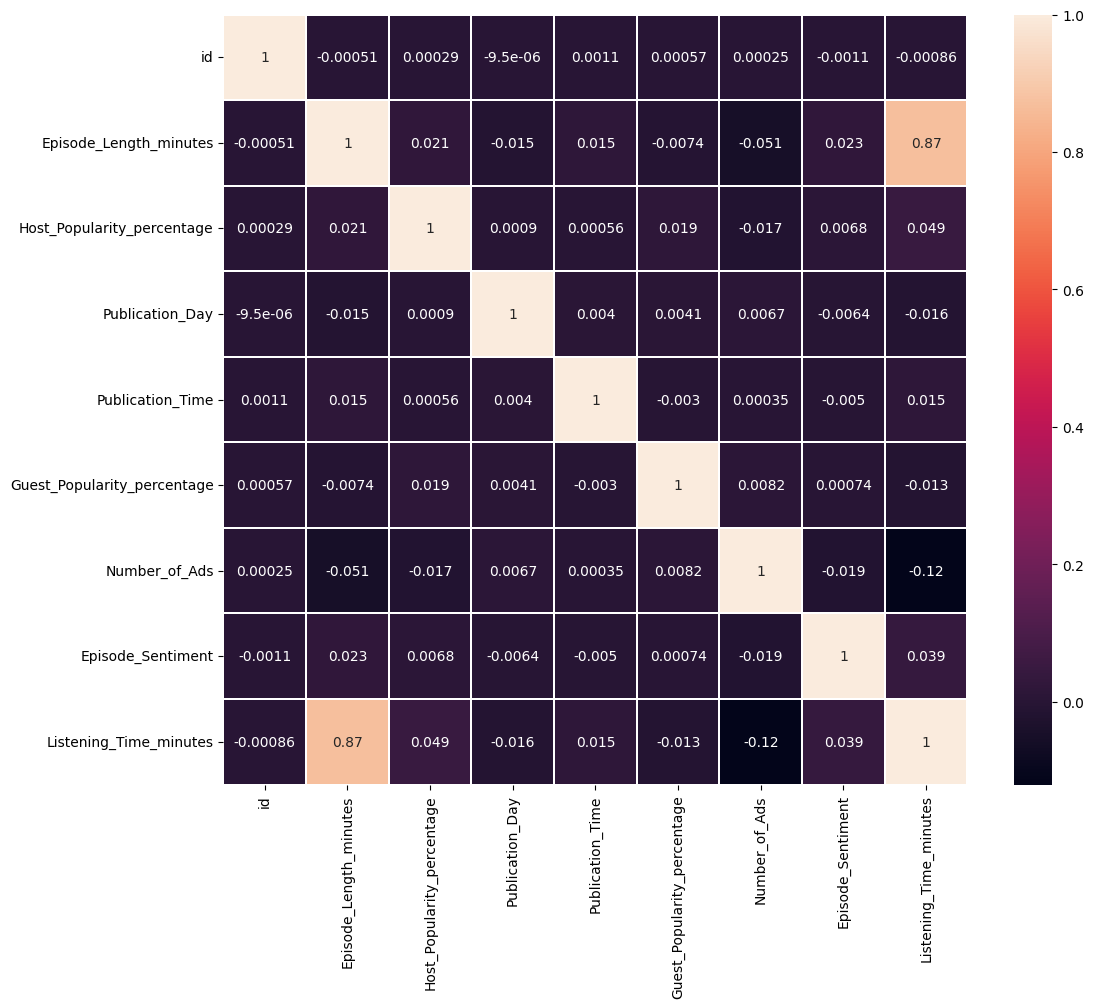

In [86]:
columns = ["id", "Episode_Length_minutes", "Host_Popularity_percentage","Publication_Day", "Publication_Time", "Guest_Popularity_percentage", "Number_of_Ads", "Episode_Sentiment", "Listening_Time_minutes"]
plt.figure(figsize=(12, 10))
sns.heatmap(data=df_united[columns].corr(), annot=True, linewidths=0.2);

In [87]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Разделение данных на обучающую и тестовую выборки
X = df_united['Episode_Length_minutes'].values.reshape(-1, 1)
y = df_united['Listening_Time_minutes'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание и обучение модели линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)

# Оценка модели на тестовой выборке
r_squared = model.score(X_test, y_test)
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f'RMSE: {rmse:.2f}')

RMSE: 13.18


In [88]:
final_model = LinearRegression()
df_test = df_test.fillna(np.mean(df_train["Episode_Length_minutes"]))
final_model.fit(X, y)

LinearRegression()

In [89]:
predict = final_model.predict(df_test['Episode_Length_minutes'].values.reshape(-1, 1))
df_sample['Listening_Time_minutes'] = predict
df_sample.to_csv("submission.csv", index=False)